In [1]:
import pandas as pd
import numpy as np
from helper_functions import *

### Import Parameter Code Lists

In [2]:
ref_parameter_df = pd.read_csv('data/dmrs/REF_Parameter.csv')
ir_parameter_df = pd.read_csv('data/ir/ir_parameter_list.csv', dtype=str)
esmr_parameter_df = pd.read_csv('data/esmr/esmr_parameters.csv')
ir_parameter_df.drop(columns=['CATEGORY'], inplace=True)
esmr_parameter_df.drop(columns=['CATEGORY'], inplace=True)

### Find Parameters with Limits in CA based on DMR Dataset

In [3]:
data_dict = read_all_dmrs(save=True, load=False) # can change to save=False, load=True if data_dict is already saved

all_pollutants, all_parameter_codes = [], []
for year in analysis_range:
    all_pollutants = np.concatenate([all_pollutants, data_dict[year]['POLLUTANT_CODE'].unique()])
    all_parameter_codes = np.concatenate([all_parameter_codes, data_dict[year]['PARAMETER_CODE'].unique()])
unique_pollutants, unique_parameter_codes = np.unique(all_pollutants), np.unique(all_parameter_codes)
print(f'{len(unique_pollutants)} unique pollutants and {len(unique_parameter_codes)} unique parameters')

2014 DMR data has 375069 DMR events and 269 unique permits
2014 DMR data has 43691 DMR events and 142 unique permits after filtering
2015 DMR data has 370700 DMR events and 264 unique permits
2015 DMR data has 43285 DMR events and 140 unique permits after filtering
2016 DMR data has 383259 DMR events and 268 unique permits
2016 DMR data has 44070 DMR events and 144 unique permits after filtering
2017 DMR data has 524186 DMR events and 454 unique permits
2017 DMR data has 53140 DMR events and 190 unique permits after filtering
2018 DMR data has 540493 DMR events and 453 unique permits
2018 DMR data has 50577 DMR events and 186 unique permits after filtering
2019 DMR data has 527656 DMR events and 443 unique permits
2019 DMR data has 51803 DMR events and 194 unique permits after filtering
2020 DMR data has 537436 DMR events and 442 unique permits
2020 DMR data has 53075 DMR events and 196 unique permits after filtering
2021 DMR data has 532621 DMR events and 433 unique permits
2021 DMR d

In [4]:
ref_parameter_df = categorize_parameters(ref_parameter_df, parameter_sorting_dict, 'PARAMETER_DESC')
ir_parameter_df = categorize_parameters(ir_parameter_df, parameter_sorting_dict, 'IR_PARAMETER_DESC')
esmr_parameter_df = categorize_parameters(esmr_parameter_df, parameter_sorting_dict, 'ESMR_PARAMETER_DESC')

# additional categorization of Total Toxics
mask = ref_parameter_df['PARAMETER_CODE'].str.startswith(('T', 'W'))
ref_parameter_df.loc[mask, 'PARENT_CATEGORY'] = 'Total Toxics'
ref_parameter_df.loc[mask, 'SUB_CATEGORY'] = ''

# save to csv
ref_parameter_df.to_csv('processed_data/step1/REF_Parameter_categorized.csv', index=False)

/Users/dalywettermark/Documents/git/ca-sewersheds/helper_functions/categorize_parameters.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[desc_column].str.contains('|'.join(value['values']), case=value.get('case', False))
/Users/dalywettermark/Documents/git/ca-sewersheds/helper_functions/categorize_parameters.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[desc_column].str.contains('|'.join(value['values']), case=value.get('case', False))
/Users/dalywettermark/Documents/git/ca-sewersheds/helper_functions/categorize_parameters.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[desc_column].str.contains('|'.join(value['values']), case=value.get('case', False))


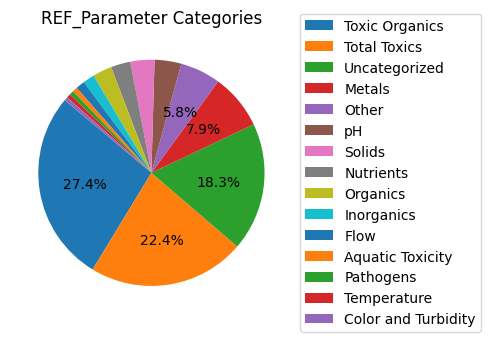

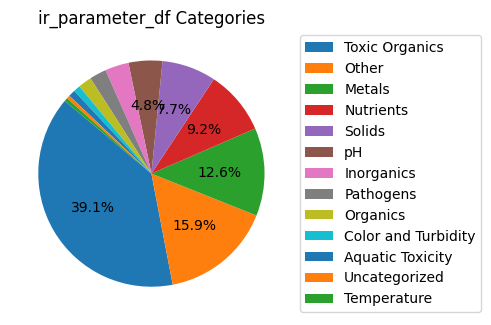

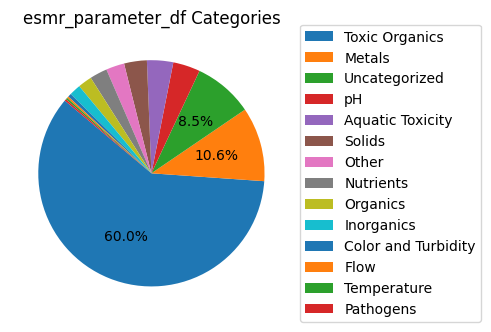

In [5]:
plot_pie_counts(ref_parameter_df, 'REF_Parameter Categories')
plot_pie_counts(ir_parameter_df, 'ir_parameter_df Categories')
plot_pie_counts(esmr_parameter_df, 'esmr_parameter_df Categories')

### Create list of parameter codes, names, and matched ESMR parameter names

In [6]:
dmr_params_df = pd.DataFrame({'PARAMETER_CODE': unique_parameter_codes}).merge(
    ref_parameter_df[['PARAMETER_CODE', 'PARAMETER_DESC', 'POLLUTANT_CODE', 'PARENT_CATEGORY', 'SUB_CATEGORY']].astype({'POLLUTANT_CODE': int}),
    on='PARAMETER_CODE', how='left'
)

if save:
    esmr_data = read_esmr(save=False, load=True)
    esmr_params_df = pd.DataFrame({'PARAMETER_DESC': esmr_data['parameter'].unique()}).merge(
        dmr_params_df[['PARAMETER_DESC', 'PARAMETER_CODE']], on='PARAMETER_DESC', how='left'
    )
    esmr_params_df.to_csv('processed_data/step1/esmr_unique_parameters.csv', index=False)
if load:
    esmr_params_df = pd.read_csv('processed_data/step1/esmr_unique_parameters.csv')

esmr_params_df['normalized_desc'] = esmr_params_df['PARAMETER_DESC'].apply(normalize_param_desc)
dmr_params_df['ESMR_PARAMETER_DESC_MATCHED'] = dmr_params_df.apply(lambda row: match_parameter_desc(row, esmr_params_df), axis=1)
print(f'{len(dmr_params_df["ESMR_PARAMETER_DESC_MATCHED"].unique()) - 1} out of {len(dmr_params_df)} parameter names automatically matched to ESMR PARAMETER_DESC in REF_PARAMETER.csv')
dmr_esmr_mapping_manual = pd.read_csv('processed_data/step1/dmr_esmr_mapping_manual.csv')
dmr_params_df['ESMR_PARAMETER_DESC_MANUAL'] = dmr_esmr_mapping_manual['ESMR_PARAMETER_DESC_MANUAL'].fillna('') # Update dmr_params_df with manual mappings
print(f'{len(dmr_params_df["ESMR_PARAMETER_DESC_MANUAL"].unique()) - 1} out of {len(dmr_params_df)} parameter names manually mapped to ESMR PARAMETER_DESC in REF_PARAMETER.csv')

dmr_params_df['ESMR_PARAMETER_DESC'] = dmr_params_df.apply(
        lambda row: row['ESMR_PARAMETER_DESC_MATCHED'] if row['ESMR_PARAMETER_DESC_MATCHED'] != '' 
        else (row['ESMR_PARAMETER_DESC_MANUAL'] if row['ESMR_PARAMETER_DESC_MANUAL'] != '' else ''),
        axis=1)

dmr_params_df.drop(columns=['ESMR_PARAMETER_DESC_MATCHED', 'ESMR_PARAMETER_DESC_MANUAL'], inplace=True)
dmr_params_df.rename(columns={'PARAMETER_DESC': 'DMR_PARAMETER_DESC'}, inplace=True)
dmr_params_df.to_csv('processed_data/step1/dmr_esmr_mapping.csv', index=False)

99 out of 252 parameter names automatically matched to ESMR PARAMETER_DESC in REF_PARAMETER.csv
66 out of 252 parameter names manually mapped to ESMR PARAMETER_DESC in REF_PARAMETER.csv
